## Objective


### Predicting-University-Admissions

Using the supplied predictive variables (GRE score, TOEFL score, University Rating, etc) to predict the likelihood of admission of a new candidate.

### Evaluation Criteria

The best model should be the one that evaluates to have the lowest RMSE overall, and please indicate the error you get on validation set containing the last 100 observations.

### Expected Submission

Please submit a Kernel where the final cell outputs the RMSE score on the final 100 observations.

### Dataset

The dataset contains several arguments(basically the inputs you need to provide) which are considered for the application for Masters Programs. The parameters included are :

- `GRE Scores` ( out of 340 )

- `TOEFL Scores` ( out of 120 )

- `Under Grad University Rating` ( out of 5 ) 

- `Statement of Purpose` (out of 5 )

- `Letter of Recommendation Strength` ( out of 5 )

- `Undergraduate GPA` ( out of 10 ) 

- `Research Experience` ( either 0 or 1 )

- `Chance of Admit` ( ranging from 0 to 1 )

# Setup


## Importing the necessary libraries

First, let's make sure this notebook works well in both `python 2 and 3`, import a few common modules, ensure `MatplotLib plots` figures `inline` and prepare a `function` to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import pandas as pd  # data processing
import numpy as np   # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_IMAGE_ID = "images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, PROJECT_IMAGE_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# sns.set_style('darkgrid')
# from matplotlib import pyplot

# for advanced visualizations
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
pip --version

pip 19.0.3 from C:\Users\Sillians\Anaconda3\lib\site-packages\pip (python 3.7)

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip3 install --upgrade pip

Requirement already up-to-date: pip in c:\users\sillians\appdata\local\packages\pythonsoftwarefoundation.python.3.7_qbz5n2kfra8p0\localcache\local-packages\python37\site-packages (20.2.3)


# Get the data

### Here is the function to fetch the data:

In [4]:
import os
# import tarfile
from six.moves import urllib
#  data/Admission_Predict.csv

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/HamoyeHQ/01-University-Admissions/master/" 
DATA_PATH = os.path.join("data")
DATA_URL = DOWNLOAD_ROOT + "data/Admission_Predict.csv"

def fetch_Admission_data(admission_url=DATA_URL, admission_path=DATA_PATH):
    os.makedirs(admission_path, exist_ok=True)
    csv_path = os.path.join(admission_path, "Admission_Predict.csv")
    urllib.request.urlretrieve(admission_url, csv_path)
    admission_csv = pd.read_csv(csv_path)
#     admission_csv.extractall(path=admission_path)
#     admission_csv.close()

Now when you call `fetch_admission_data()`, it creates a `data/Admission_Predict directory` in your workspace, downloads the `Admission_Predict.csv` file, and extracts the `Admission_Predict.csv` from it in this directory.

In [5]:
fetch_Admission_data()

Now let’s load the data using `Pandas`. Once again you should write a small function to load the data:

In [6]:
import pandas as pd

def load_admission_data(admission_path=DATA_PATH):
    csv_path = os.path.join(admission_path, "Admission_Predict.csv")
    return pd.read_csv(csv_path)

#### Take a Quick Look at the Data Structure
Let’s take a look at the top 10 rows using the DataFrame’s `head() method`

In [7]:
dataset = load_admission_data()
dataset.head(10)

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   
5           6        330          115                  5  4.5   3.0  9.34   
6           7        321          109                  3  3.0   4.0  8.20   
7           8        308          101                  2  3.0   4.0  7.90   
8           9        302          102                  1  2.0   1.5  8.00   
9          10        323          108                  3  3.5   3.0  8.60   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  
5         1              0.90  
6         1              0.75  
7         0              0.68  
8         0              0.50  
9         0              0.45

This function returns a `Pandas DataFrame object` containing all the data.

In [8]:
dataset.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

#### Rename some Columns

In [9]:
dataset.rename(columns={'GRE Score':'Gre_Score','TOEFL Score':'TOEFL_Score','University Rating':'University_Rating',
                                       'LOR ':'LOR',  'Chance of Admit ':'Chance_of_Admit'}, inplace = True)

In [10]:
dataset.columns

Index(['Serial No.', 'Gre_Score', 'TOEFL_Score', 'University_Rating', 'SOP',
       'LOR', 'CGPA', 'Research', 'Chance_of_Admit'],
      dtype='object')

Each row represents one Feature/Attribute. There are 9 attributes: 
* Serial No. 
* Gre_Score 
* TOEFL_Score 
* University_Rating 
* SOP
* LOR 
* CGPA 
* Research 
* Chance_of_Admit

In [11]:
# Let’s take a look at the last 10 rows
dataset.tail(10)

Serial No.  Gre_Score  TOEFL_Score  University_Rating  SOP  LOR  CGPA  \
390         391        314          102                  2  2.0  2.5  8.24   
391         392        318          106                  3  2.0  3.0  8.65   
392         393        326          112                  4  4.0  3.5  9.12   
393         394        317          104                  2  3.0  3.0  8.76   
394         395        329          111                  4  4.5  4.0  9.23   
395         396        324          110                  3  3.5  3.5  9.04   
396         397        325          107                  3  3.0  3.5  9.11   
397         398        330          116                  4  5.0  4.5  9.45   
398         399        312          103                  3  3.5  4.0  8.78   
399         400        333          117                  4  5.0  4.0  9.66   

     Research  Chance_of_Admit  
390         0             0.64  
391         0             0.71  
392         1             0.84  
393         0             0.77  
394         1             0.89  
395         1             0.82  
396         1             0.84  
397         1             0.91  
398         0             0.67  
399         1             0.95

In [12]:
# shape of the dataset (Rows and Columns)
print (f"dataset has {dataset.shape[0]} rows and {dataset.shape[1]} columns")

dataset has 400 rows and 9 columns


In [13]:
# check for duplicates 
assert dataset.duplicated().any() == False

In [14]:
# Gives use the count of different types of objects.
dataset.dtypes.value_counts()

int64      5
float64    4
dtype: int64

The `info()` method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s `type` and `number` of `non-null values`.

In [15]:
# Check for info about the dataset, for missing values and data type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
Serial No.           400 non-null int64
Gre_Score            400 non-null int64
TOEFL_Score          400 non-null int64
University_Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance_of_Admit      400 non-null float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


The `describe()` method shows a summary of the numerical attributes. 

In [16]:
# Descriptive analysis of the data
dataset.describe().T

count        mean         std     min     25%     50%  \
Serial No.         400.0  200.500000  115.614301    1.00  100.75  200.50   
Gre_Score          400.0  316.807500   11.473646  290.00  308.00  317.00   
TOEFL_Score        400.0  107.410000    6.069514   92.00  103.00  107.00   
University_Rating  400.0    3.087500    1.143728    1.00    2.00    3.00   
SOP                400.0    3.400000    1.006869    1.00    2.50    3.50   
LOR                400.0    3.452500    0.898478    1.00    3.00    3.50   
CGPA               400.0    8.598925    0.596317    6.80    8.17    8.61   
Research           400.0    0.547500    0.498362    0.00    0.00    1.00   
Chance_of_Admit    400.0    0.724350    0.142609    0.34    0.64    0.73   

                        75%     max  
Serial No.         300.2500  400.00  
Gre_Score          325.0000  340.00  
TOEFL_Score        112.0000  120.00  
University_Rating    4.0000    5.00  
SOP                  4.0000    5.00  
LOR                  4.0000    5.00  
CGPA                 9.0625    9.92  
Research             1.0000    1.00  
Chance_of_Admit      0.8300    0.97

The `count`, `mean`, `min`, and `max` rows are self-explanatory. The `std` row shows the `standard deviation`, which measures how dispersed the values are. 

The `25%`, `50%`, and `75%` rows show the corresponding `percentiles`: a percentile indicates the value below which a given percentage of observations in a group of observations falls. For example, `25%` of the `students` have a `GCPA` lower than `8.17`, while `50%` are lower than `8.61` and `75%` are lower than `9.06`. These are often called the `25th percentile` (or `1st quartile`), the `median`, and the `75th percentile` (or `3rd quartile`).

#### Checking for Null values

In [17]:
dataset.isnull().sum()

Serial No.           0
Gre_Score            0
TOEFL_Score          0
University_Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance_of_Admit      0
dtype: int64

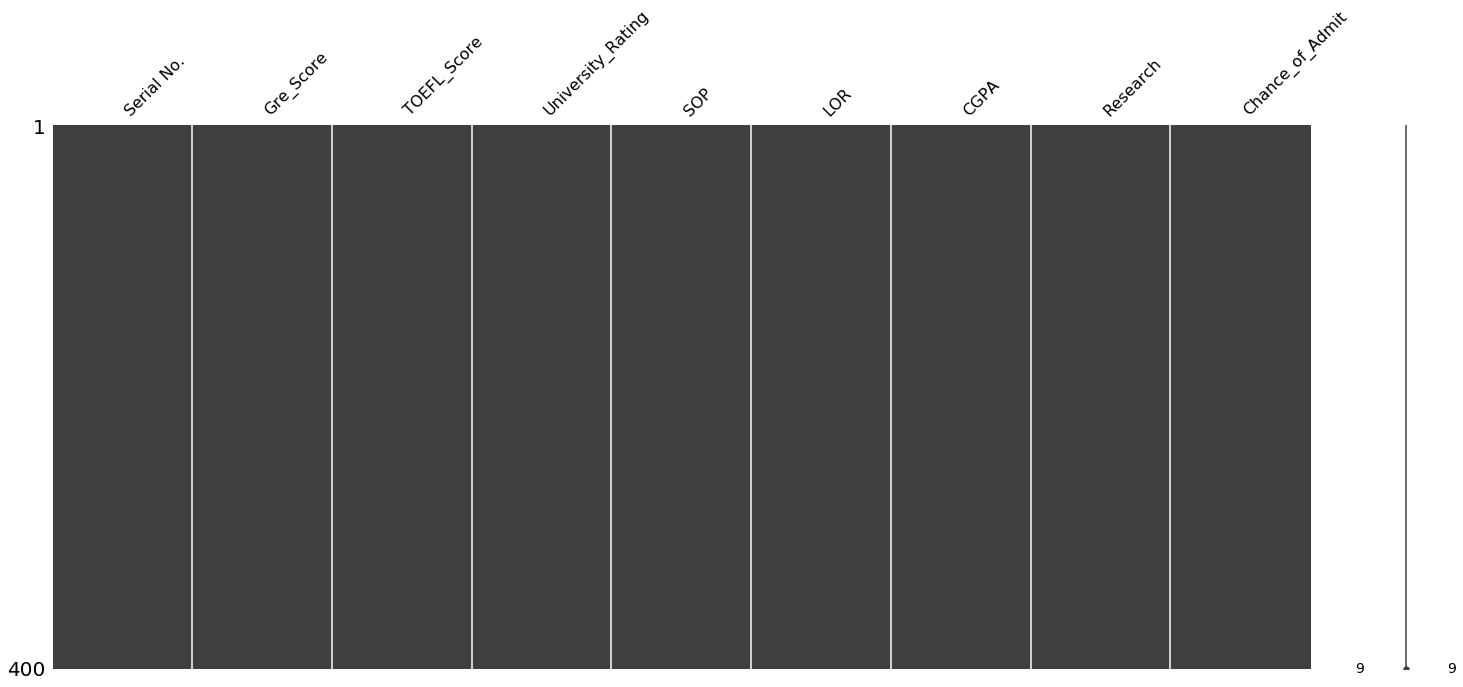

In [18]:
# A graphical view/representation of columns(features) with missing data using missingno
# Missingno library offers a very nice way to visualize the distribution of NaN values.
import missingno as msno
msno.matrix(dataset)
plt.show()

Drop the `Serial No` column which for me is not relevant for this project

In [19]:
dataset = dataset.drop(['Serial No.'], axis=1)
dataset.head()

Gre_Score  TOEFL_Score  University_Rating  SOP  LOR  CGPA  Research  \
0        337          118                  4  4.5  4.5  9.65         1   
1        324          107                  4  4.0  4.5  8.87         1   
2        316          104                  3  3.0  3.5  8.00         1   
3        322          110                  3  3.5  2.5  8.67         1   
4        314          103                  2  2.0  3.0  8.21         0   

   Chance_of_Admit  
0             0.92  
1             0.76  
2             0.72  
3             0.80  
4             0.65

### Check for General Correlation of Features

In [20]:
pearson_corr = dataset.corr(method='pearson')
pearson_corr

Gre_Score  TOEFL_Score  University_Rating       SOP  \
Gre_Score           1.000000     0.835977           0.668976  0.612831   
TOEFL_Score         0.835977     1.000000           0.695590  0.657981   
University_Rating   0.668976     0.695590           1.000000  0.734523   
SOP                 0.612831     0.657981           0.734523  1.000000   
LOR                 0.557555     0.567721           0.660123  0.729593   
CGPA                0.833060     0.828417           0.746479  0.718144   
Research            0.580391     0.489858           0.447783  0.444029   
Chance_of_Admit     0.802610     0.791594           0.711250  0.675732   

                        LOR      CGPA  Research  Chance_of_Admit  
Gre_Score          0.557555  0.833060  0.580391         0.802610  
TOEFL_Score        0.567721  0.828417  0.489858         0.791594  
University_Rating  0.660123  0.746479  0.447783         0.711250  
SOP                0.729593  0.718144  0.444029         0.675732  
LOR                1.000000  0.670211  0.396859         0.669889  
CGPA               0.670211  1.000000  0.521654         0.873289  
Research           0.396859  0.521654  1.000000         0.553202  
Chance_of_Admit    0.669889  0.873289  0.553202         1.000000

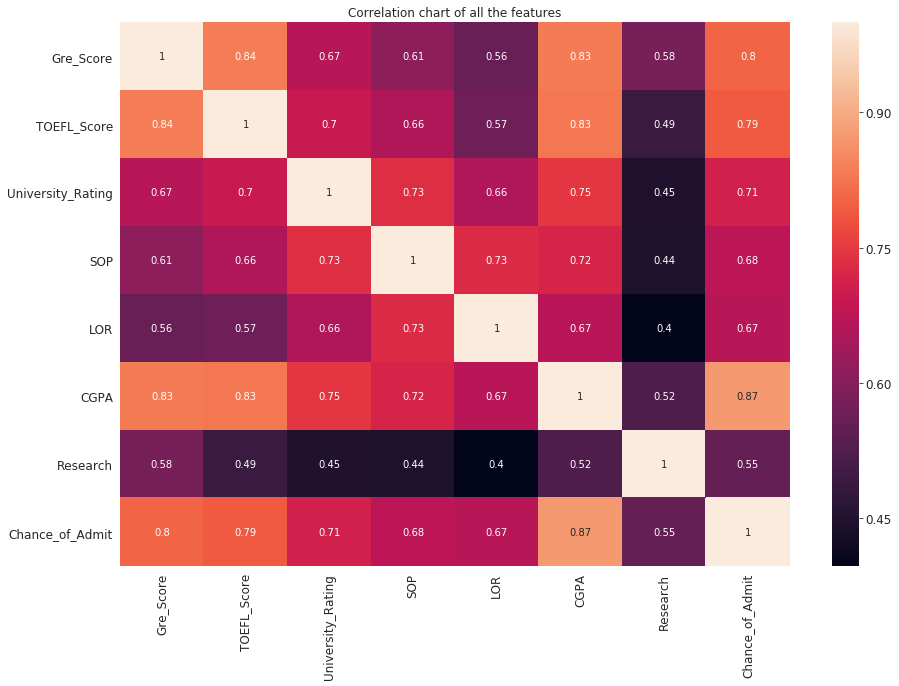

In [21]:
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(dataset.corr(), annot=True)
    plt.title('Correlation chart of all the features')

### Exploratory Data Analysis

### Python Profiling
Generates profile reports from a pandas DataFrame. The pandas `df.describe()` function is great but a little basic for serious exploratory data analysis. `pandas_profiling` extends the pandas DataFrame with `df.profile_report()` for quick data analysis.

For each column the following statistics - if relevant for the column type - are presented in an interactive HTML report:

* **Type inference:** detect the types of columns in a dataframe.
* **Essentials:** type, unique values, missing values.
* **Quantile statistics** like minimum value, Q1, median, Q3, maximum, range, interquartile range.
* **Descriptive statistics** like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness.
* **Most frequent values**
* **Histogram**
* **Correlations** highlighting of highly correlated variables, Spearman, Pearson and Kendall matrices
* **Missing values** matrix, count, heatmap and dendrogram of missing values
* **Text analysis** learn about categories (Uppercase, Space), scripts (Latin, Cyrillic) and blocks (ASCII) of text data.

In [22]:
from pandas_profiling import ProfileReport
profile = ProfileReport(dataset, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [23]:
# The HTML report can be included in a Juyter notebook
profile.to_notebook_iframe()

In [24]:
# Generating reports interactively through widgets
profile.to_widgets()
# profile

In [25]:
# Saving the report
# If you want to generate a HTML report file, save the ProfileReport to an object and use the to_file() function:

profile.to_file(output_file="Pandas_profiling_report.html")

In [26]:
# Alternatively, you can obtain the data as json:

# As a string
json_data = profile.to_json()

# As a file
profile.to_file(output_file="Pandas_profiling_report.json")

### Understand the distribution of the features 

Another quick way to get a feel of the type of data you are dealing with is to plot a `histogram` for each `numerical` attribute. A `histogram` shows the number of `instances` (on the `vertical axis`) that have a given `value range` (on the `horizontal axis`). You can either plot this one attribute at a time, or you can call the `hist()` method on the whole dataset, and it will plot a `histogram` for each numerical attribute.

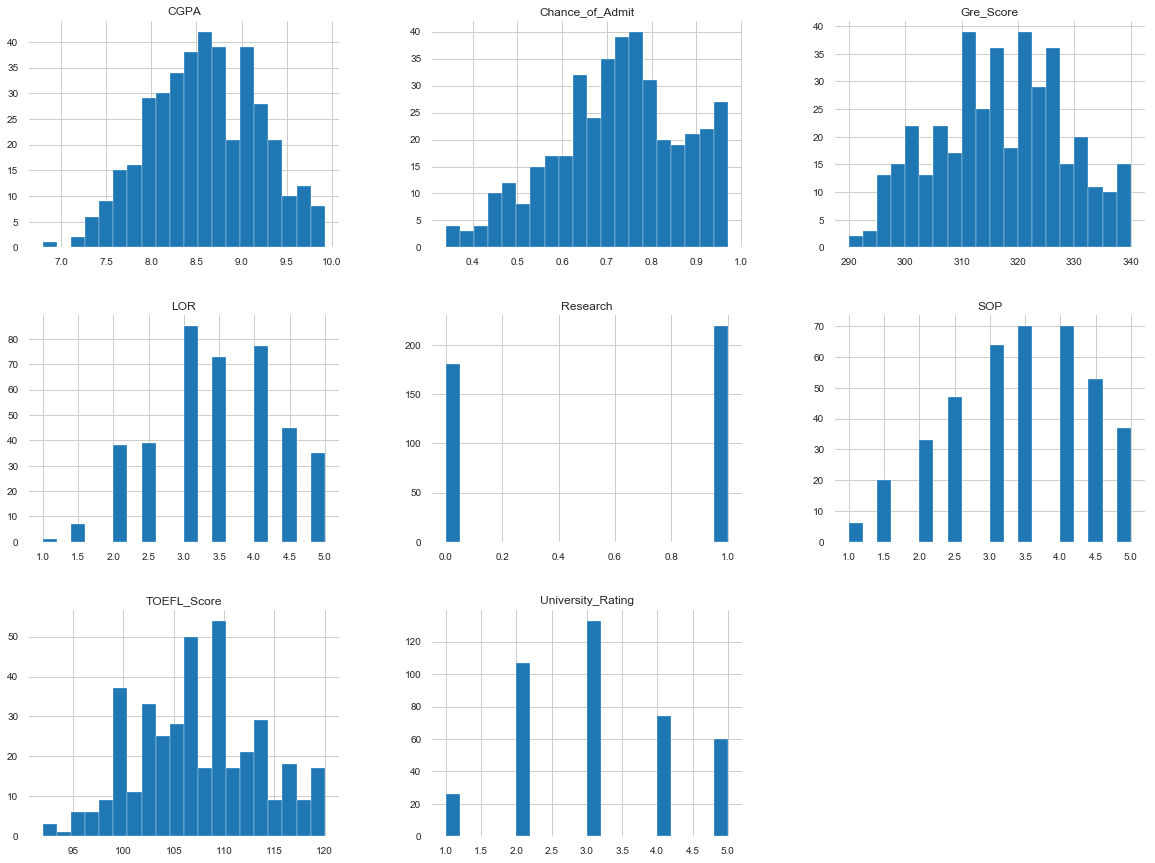

In [27]:
# Data distribution
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins=20, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

#### Notice a few things in these histograms:

- 



- 



- 



#### Lets check out those with top Probability of getting Admitted

In [28]:
top_prob = dataset[(dataset['Gre_Score']>=330) & (dataset['TOEFL_Score']>=115) & \
                   (dataset['CGPA']>=9.5)].sort_values(by=['Chance_of_Admit'],ascending=False)
top_prob

Gre_Score  TOEFL_Score  University_Rating  SOP  LOR  CGPA  Research  \
203        334          120                  5  4.0  5.0  9.87         1   
24         336          119                  5  4.0  3.5  9.80         1   
143        340          120                  4  4.5  4.0  9.92         1   
202        340          120                  5  4.5  4.5  9.91         1   
385        335          117                  5  5.0  5.0  9.82         1   
213        333          119                  5  5.0  4.5  9.78         1   
81         340          120                  4  5.0  5.0  9.50         1   
148        339          116                  4  4.0  3.5  9.80         1   
399        333          117                  4  5.0  4.0  9.66         1   
372        336          119                  4  4.5  4.0  9.62         1   
212        338          120                  4  5.0  5.0  9.66         1   
23         334          119                  5  5.0  4.5  9.70         1   
193        336          118                  5  4.5  5.0  9.53         1   
120        335          117                  5  5.0  5.0  9.56         1   
70         332          118                  5  5.0  5.0  9.64         1   
25         340          120                  5  4.5  4.5  9.60         1   
253        335          115                  4  4.5  4.5  9.68         1   
361        334          116                  4  4.0  3.5  9.54         1   
0          337          118                  4  4.5  4.5  9.65         1   
47         339          119                  5  4.5  4.0  9.70         0   

     Chance_of_Admit  
203             0.97  
24              0.97  
143             0.97  
202             0.97  
385             0.96  
213             0.96  
81              0.96  
148             0.96  
399             0.95  
372             0.95  
212             0.95  
23              0.95  
193             0.94  
120             0.94  
70              0.94  
25              0.94  
253             0.93  
361             0.93  
0               0.92  
47              0.89

### Data Storytelling

- 

- 



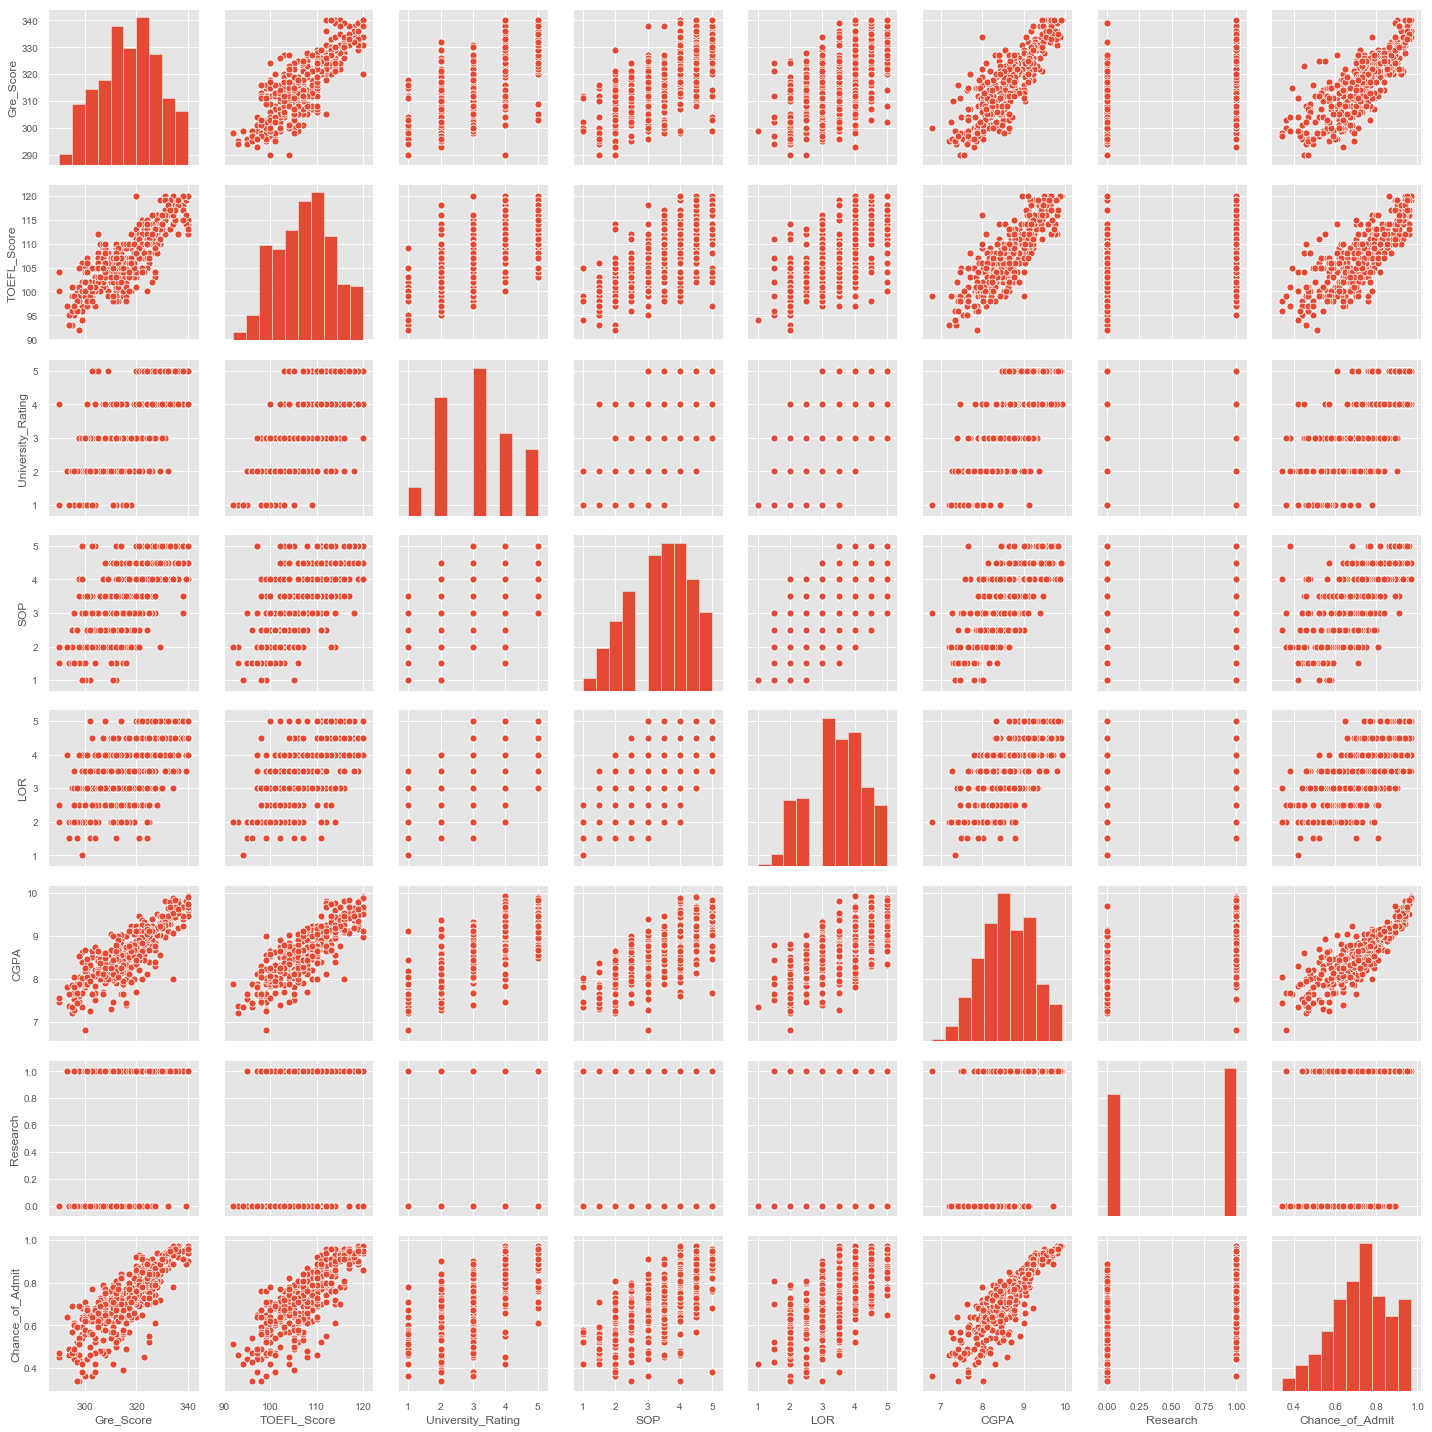

In [29]:
# plotting a pair plot to see the correlations

plt.rcParams['figure.figsize'] = (20,21)
plt.style.use('ggplot')

sns.pairplot(dataset, palette="crest")
# sns.color_palette("flare", as_cmap=True)
plt.show()

### Data Storyteling

- 

- 

- 

- 

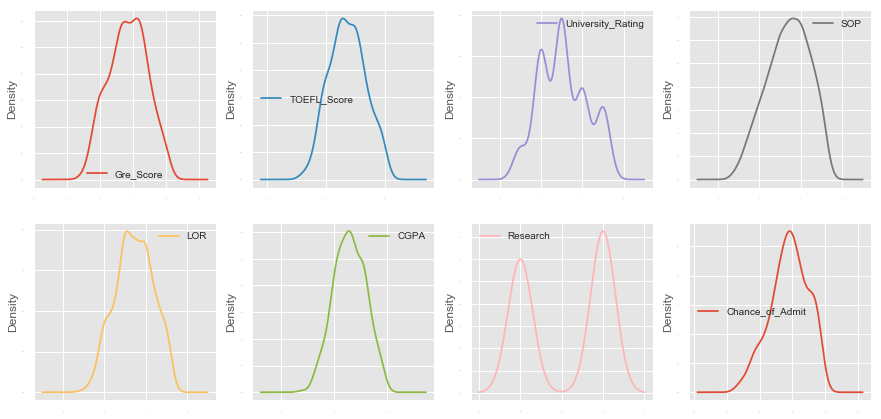

In [30]:
# density plot
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=False, fontsize=1, figsize=(15,15))
plt.show()

### Data Storytelling

- 


- 




### Check for Outliers in the Temperature Features

Interval of values not considered Outliers

- [Q1 – 1.5 (IQR) , Q3 + 1.5 (IQR) ] (i.e. IQR = Q3 - Q1)

- Values not lying within this interval are considered outliers. Knowing the values of Q1 and Q3 is fundamental for this calculation to take place.


### Methods for removing Outliers

- `Remove the outliers:` This is only possible when the proportion of outliers to meaningful values is quite low, and the data values are not on a time series scale. If the proportion of outliers is high, then removing these values will hurt the richness of data, and models applied won’t be able to capture the true essence that lies within. However, in case the data is of a time series nature, removing outliers from the data won’t be feasible, the reason being that for a time series model to train effectively, data should be continuous with respect to time. Removing outliers in this case will introduce breaks within the continuous distribution.

- `Replace outliers with means:` Another way to approach this is by taking the mean of values lying with the interval. calculate the mean, and use these to replace the outliers. This will successfully transform the outliers in line with the valid observations; however, this will remove the anomalies that were otherwise present in the dataset, and their findings could present interesting insights.

- `Transform the outlier values:` Another way to cop up with outliers is to limit them to the upper and lower boundaries of acceptable data. The upper boundary can be calculated by plugging in the values of Q3 and IQR into Q3 + 1.5IQR and the lower boundary can be calculated by plugging in the values of Q1 and IQR into Q1 – 1.5IQR.

- `Variable transformation:` Transformations are used to convert the inherited distribution into a normal distribution. Outliers bring non-normality to the data and thus transforming the variable can reduce the influence of outliers. Methodologies of transformation include, but are not limited to, natural log, conversion of data into ratio variables, and so on.

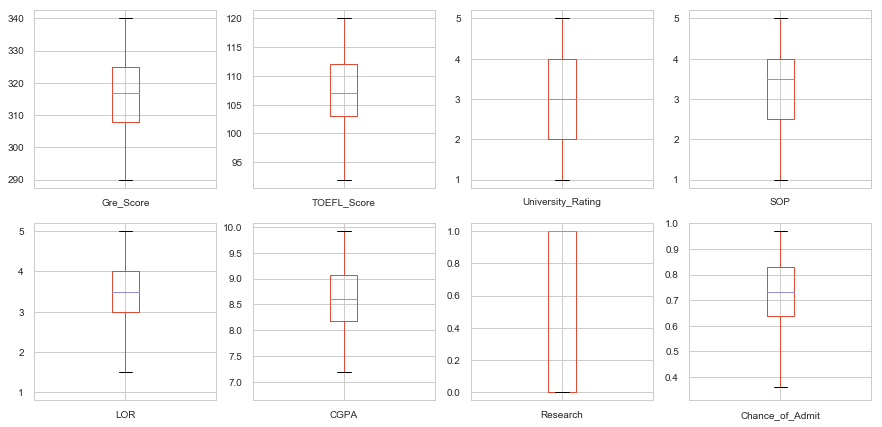

In [31]:
# box and whisker plots
sns.set_style("whitegrid")
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15, 15))
plt.show()

### Data Storytelling

- 

- 


In [32]:
dataset.columns

Index(['Gre_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance_of_Admit'],
      dtype='object')

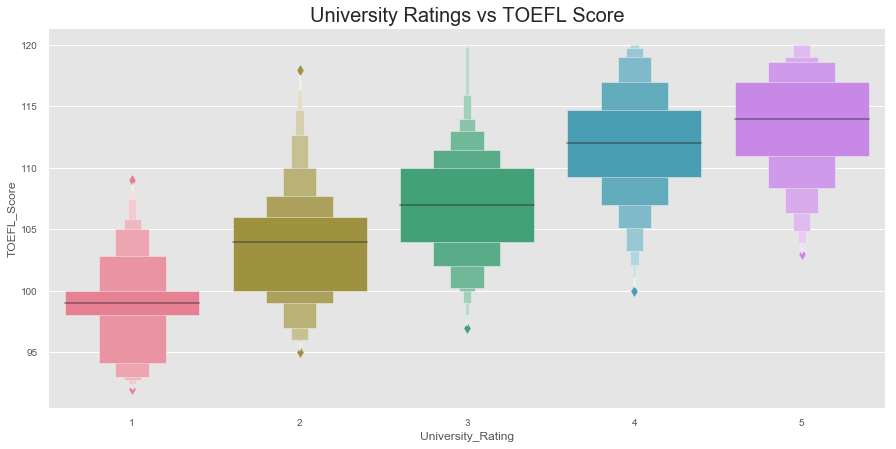

In [33]:
# University Ratings vs TOEFL Score
plt.rcParams['figure.figsize'] = (15, 7)
plt.style.use('ggplot')

sns.boxenplot(dataset['University_Rating'], dataset['TOEFL_Score'], palette='husl')
plt.title('University Ratings vs TOEFL Score', fontsize = 20)
plt.show()

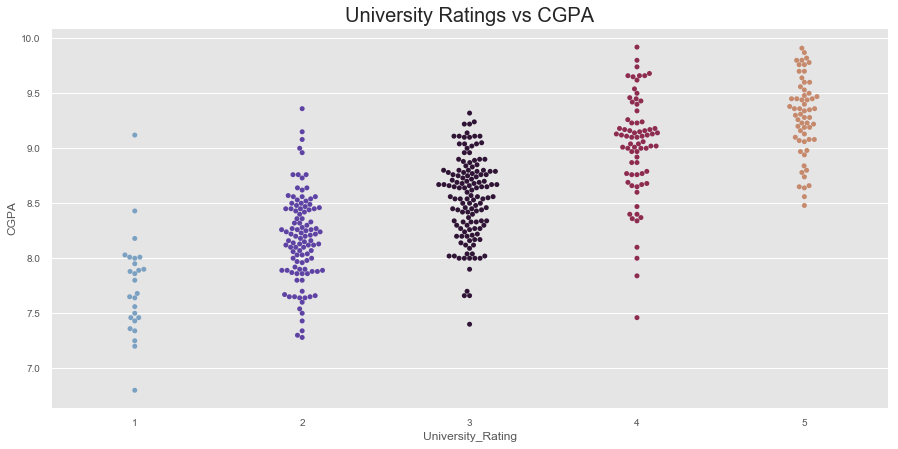

In [34]:
# University Rating vs CGPA
plt.rcParams['figure.figsize'] = (15, 7)
plt.style.use('ggplot')

sns.swarmplot(dataset['University_Rating'], dataset['CGPA'], palette='twilight')
plt.title('University Ratings vs CGPA', fontsize = 20)
plt.show()

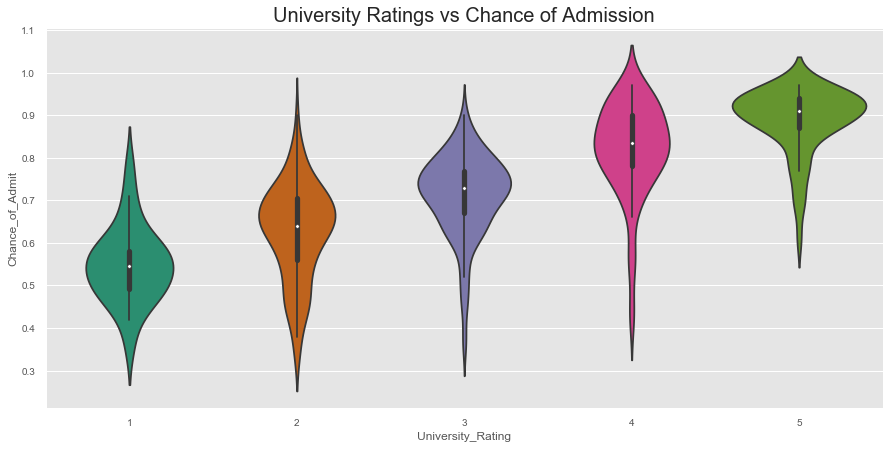

In [35]:
# University Ratings vs Chance of Admission
plt.rcParams['figure.figsize'] = (15, 7)
plt.style.use('ggplot')

sns.violinplot(dataset['University_Rating'], dataset['Chance_of_Admit'], palette="Dark2")
plt.title('University Ratings vs Chance of Admission', fontsize = 20)
plt.show()

#### A graphical Understanding of the relation between different factors responsible for graduate admissions

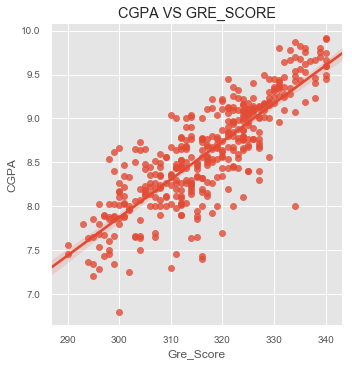

In [36]:
fig=sns.lmplot(x='Gre_Score',y='CGPA',data=dataset)
plt.title("CGPA VS GRE_SCORE")
plt.show()

### Data Storytelling

* 

* 

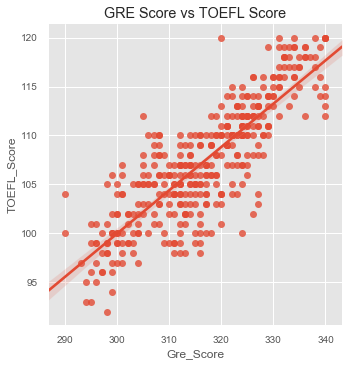

In [37]:
fig = sns.lmplot(x="Gre_Score", y="TOEFL_Score", data=dataset)
plt.title("GRE Score vs TOEFL Score")
plt.show()

###  Data Storytelling

* 



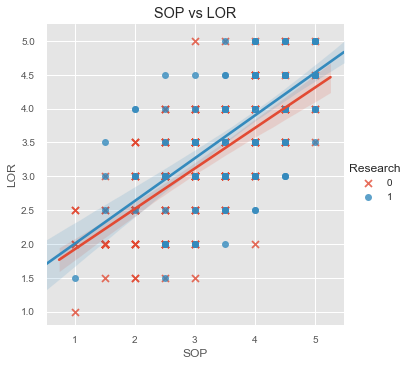

In [38]:
fig = sns.lmplot(x="SOP", y="LOR", data=dataset, hue="Research", markers=["x", "o"])
plt.title("SOP vs LOR")
plt.show()

### Data Storytelling

_

_

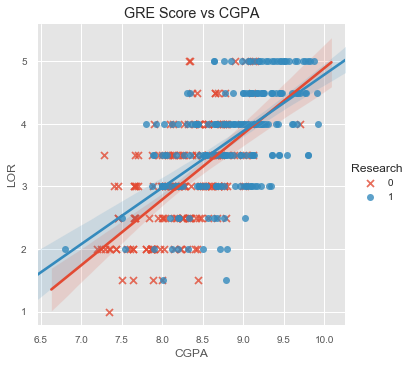

In [39]:
fig = sns.lmplot(x="CGPA", y="LOR", data=dataset, hue="Research", markers=["x", "o"])
plt.title("GRE Score vs CGPA")
plt.show()

### Data Storytelling

* 



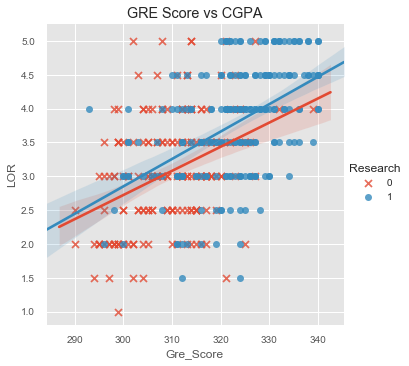

In [40]:
fig = sns.lmplot(x="Gre_Score", y="LOR", data=dataset, hue="Research", markers=["x", "o"])
plt.title("GRE Score vs CGPA")
plt.show()

### Data Storytelling

*

*

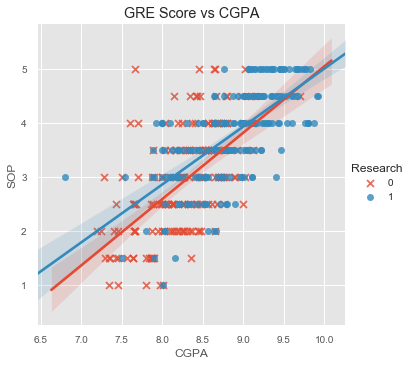

In [41]:
fig = sns.lmplot(x="CGPA", y="SOP", data=dataset, hue='Research', markers=["x", "o"])
plt.title("GRE Score vs CGPA")
plt.show()

### Data Storytelling

* 

* 

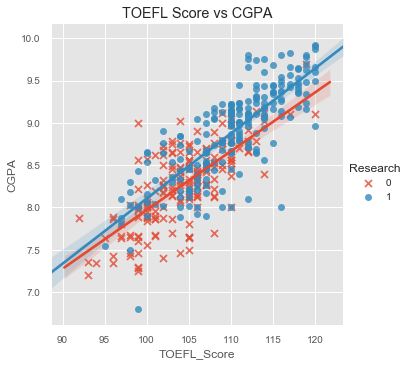

In [42]:
fig = sns.lmplot(x="TOEFL_Score", y="CGPA", data=dataset, hue='Research', markers=["x", "o"])
plt.title("TOEFL Score vs CGPA")
plt.show()

### Data Storytelling

* 

* 

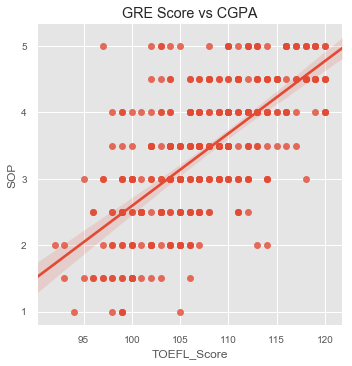

In [43]:
fig = sns.lmplot(x="TOEFL_Score", y="SOP", data=dataset)
plt.title("GRE Score vs CGPA")
plt.show()

### Data Storytelling

* 

* 

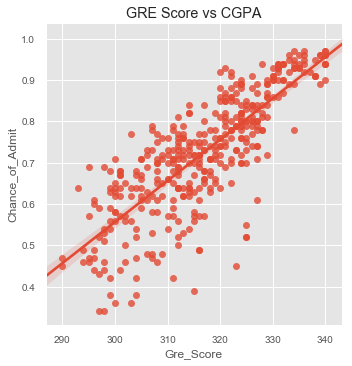

In [44]:
fig = sns.lmplot(x="Gre_Score", y="Chance_of_Admit", data=dataset)
plt.title("GRE Score vs CGPA")
plt.show()

### Data Storytelling

* 

* 

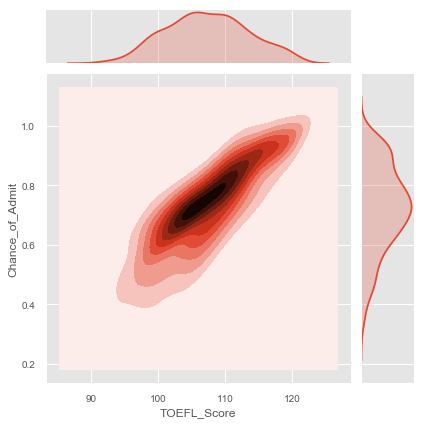

In [45]:
fig=sns.jointplot(x='TOEFL_Score',y='Chance_of_Admit',data=dataset,kind='kde')
plt.show()

### Data Storytelling

* 

* 

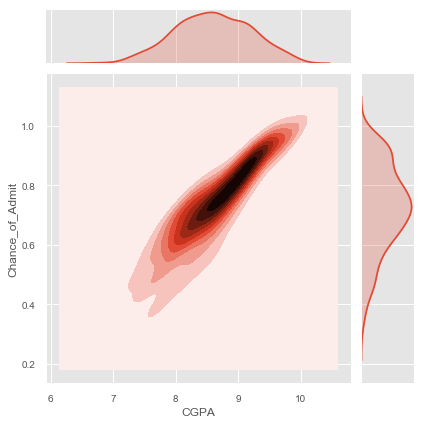

In [46]:
fig=sns.jointplot(x='CGPA',y='Chance_of_Admit',data=dataset,kind='kde')
plt.show()

### Data Storytelling

* This plot reveals a few things. First, the `correlation` is indeed `very strong`; you can clearly see the `upward trend` and the points are not too dispersed. 

* 

* 

#### Check for Multicollinearity

- `Colinearity` is the state where `two variables` are `highly correlated` and contain `similiar information` about the `variance` within a given dataset. To detect `colinearity` among variables, simply create a `correlation matrix` and find variables with large absolute values. 


- `Multicollinearity` occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. 

In [47]:
dataset.corr()

Gre_Score  TOEFL_Score  University_Rating       SOP  \
Gre_Score           1.000000     0.835977           0.668976  0.612831   
TOEFL_Score         0.835977     1.000000           0.695590  0.657981   
University_Rating   0.668976     0.695590           1.000000  0.734523   
SOP                 0.612831     0.657981           0.734523  1.000000   
LOR                 0.557555     0.567721           0.660123  0.729593   
CGPA                0.833060     0.828417           0.746479  0.718144   
Research            0.580391     0.489858           0.447783  0.444029   
Chance_of_Admit     0.802610     0.791594           0.711250  0.675732   

                        LOR      CGPA  Research  Chance_of_Admit  
Gre_Score          0.557555  0.833060  0.580391         0.802610  
TOEFL_Score        0.567721  0.828417  0.489858         0.791594  
University_Rating  0.660123  0.746479  0.447783         0.711250  
SOP                0.729593  0.718144  0.444029         0.675732  
LOR                1.000000  0.670211  0.396859         0.669889  
CGPA               0.670211  1.000000  0.521654         0.873289  
Research           0.396859  0.521654  1.000000         0.553202  
Chance_of_Admit    0.669889  0.873289  0.553202         1.000000

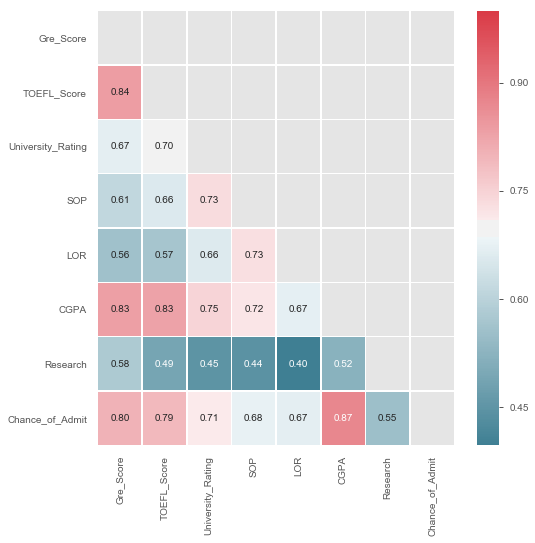

In [48]:
corr = dataset.corr()
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

#### Detecting Multicollinearity using VIF

- `Multicollinearity` can be detected via various methods. The main focus here is `VIF (Variable Inflation Factors)`. 

- `VIF` determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.

or

`VIF` score of an independent variable represents how well the variable is explained by other independent variables.


`R^2` value is determined to find out how well an independent variable is described by the other independent variables. A high value of `R^2` means that the variable is highly correlated with the other variables. This is captured by the `VIF` which is denoted below:


<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/03/multicollinearity_VIF.png"></a>


So, the closer the `R^2` value to 1, the higher the value of `VIF` and the higher the multicollinearity with the particular independent variable.

In [49]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [50]:
X = dataset.iloc[:,:-1]
calc_vif(X)

variables          VIF
0          Gre_Score  1438.451789
1        TOEFL_Score  1349.746948
2  University_Rating    22.143705
3                SOP    38.050177
4                LOR    38.411722
5               CGPA  1080.491179
6           Research     2.859938

- `VIF` starts at 1 and has no upper limit
- `VIF = 1`, no correlation between the independent variable and the other variables
- `VIF` exceeding `10` or `20` indicates high multicollinearity between this independent variable and the others

We can see here that the `‘Gre_Score’`, `‘TOEFL Score’`, and `'CGPA'` have a `high VIF` value, meaning they can be predicted by other `independent variables` in the dataset. 

- Although `correlation matrix` and `scatter plots` can also be used to find `multicollinearity`, their findings only show the `bivariate relationship` between the `independent variables`. `VIF` is preferred as it can show the correlation of a variable with a group of other variables.



#### Fixing Multicollinearity

Dropping two of the `correlated features` will help in bringing down the `multicollinearity` between correlated features:

- Dropping:

    - `Gre_Score`
    - `TOEFL Score`

In [51]:
X = dataset.drop(['Gre_Score','TOEFL_Score', 'Chance_of_Admit'],axis=1)
calc_vif(X)

variables        VIF
0  University_Rating  20.105342
1                SOP  36.461282
2                LOR  37.757426
3               CGPA  24.781833
4           Research   2.837728

Still dropping either of the `SOP` or `LOR` features to help bring down `multicollinearity` between correlated features:

In [52]:
X = dataset.drop(['SOP','Gre_Score','TOEFL_Score', 'Chance_of_Admit'],axis=1)
calc_vif(X)

variables        VIF
0  University_Rating  16.385850
1                LOR  30.936175
2               CGPA  23.071333
3           Research   2.792285

We were able to drop the variable `‘Gre_Score’`, `'TOEFL_Score'` from the dataset because its information was being captured by the `‘CGPA’` variable, and as well drop the `'SOP'` variable because its information was captured by the `'LOR'` variable. This has reduced the redundancy in our dataset.

- Dropping variables should be an `iterative process` starting with the variable having the `largest VIF` value because its trend is `highly captured` by other variables. If you do this, you will notice that `VIF` values for other variables would have reduced too, although to a varying extent.


- After dropping the `‘Gre_Score’`, `'TOEFL_Score'` and `'SOP'` variable, `VIF` values for all the variables have decreased to a varying extent.

In [53]:
dataset = dataset.drop(['SOP', 'Gre_Score', 'TOEFL_Score'], axis=1)
dataset.head()

University_Rating  LOR  CGPA  Research  Chance_of_Admit
0                  4  4.5  9.65         1             0.92
1                  4  4.5  8.87         1             0.76
2                  3  3.5  8.00         1             0.72
3                  3  2.5  8.67         1             0.80
4                  2  3.0  8.21         0             0.65

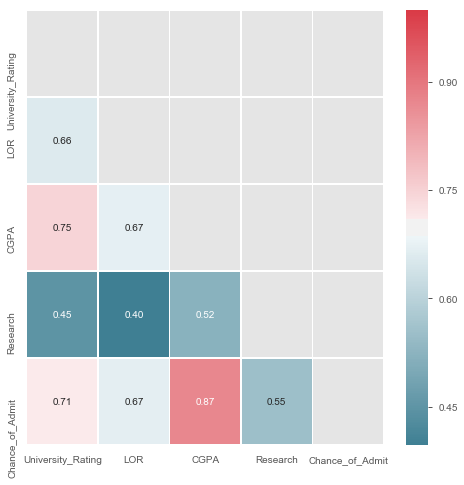

In [54]:
corr = dataset.corr()
fig, ax = plt.subplots(figsize=(8, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=dropSelf)
plt.show()

#### Compare the distribution of the Features to see if there is any need for `Normalization` or `Scaling`. 

`Normal distribution:` Also known as the `"bell curve"`, this is a specific statistical distribution where a roughly equal observations fall above and below the mean, the mean and the median are the same, and there are more observations closer to the mean. The `normal distribution` is also known as the `Gaussian distribution`.

Text(0.5, 1.0, 'Chance_of_Admit')

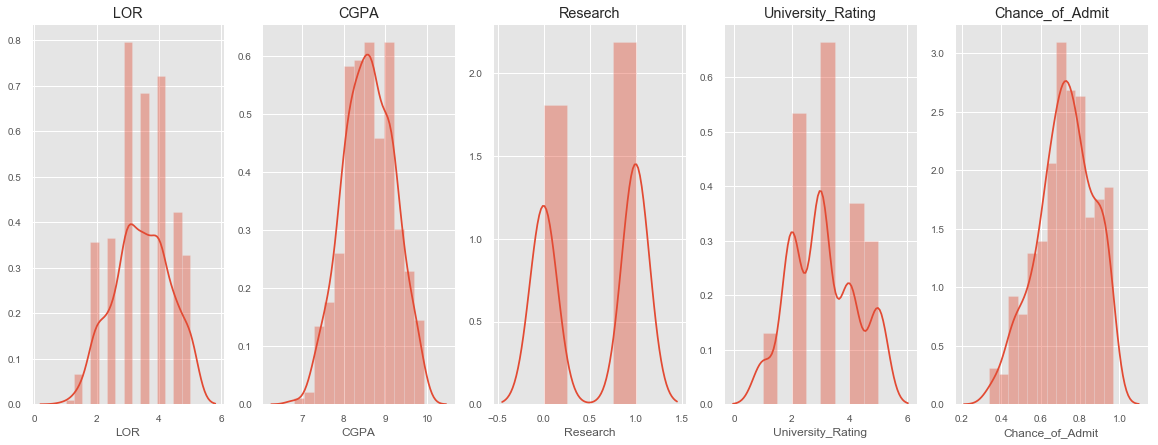

In [55]:
# plot both together to compare
fig, axs = plt.subplots(ncols=5, figsize=(20, 7))

sns.distplot(dataset['LOR'], ax=axs[0])
axs[0].set_title("LOR")

sns.distplot(dataset['CGPA'], ax=axs[1])
axs[1].set_title("CGPA")

sns.distplot(dataset['Research'], ax=axs[2])
axs[2].set_title("Research")

sns.distplot(dataset['University_Rating'], ax=axs[3])
axs[3].set_title("University_Rating")

sns.distplot(dataset['Chance_of_Admit'], ax=axs[4])
axs[4].set_title("Chance_of_Admit")

`Normalization` is a technique often applied as part of data preparation for machine learning. `Normalization` avoids these problems by creating new values that maintain the `general distribution` and `ratios` in the source data, while keeping values within a scale applied across all numeric columns used in the model. Here, our Features seems to be normally distributed, so no need to normalise the Features. Scale is `(-0.5, 10)`.

### Data Storytelling

* 

* 

In [56]:
# to make this notebook's output identical at every run
np.random.seed(42)

#### Import Modeling Libraries

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso,Ridge,BayesianRidge,ElasticNet,SGDRegressor
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#### Device a better Strategy for Modelling

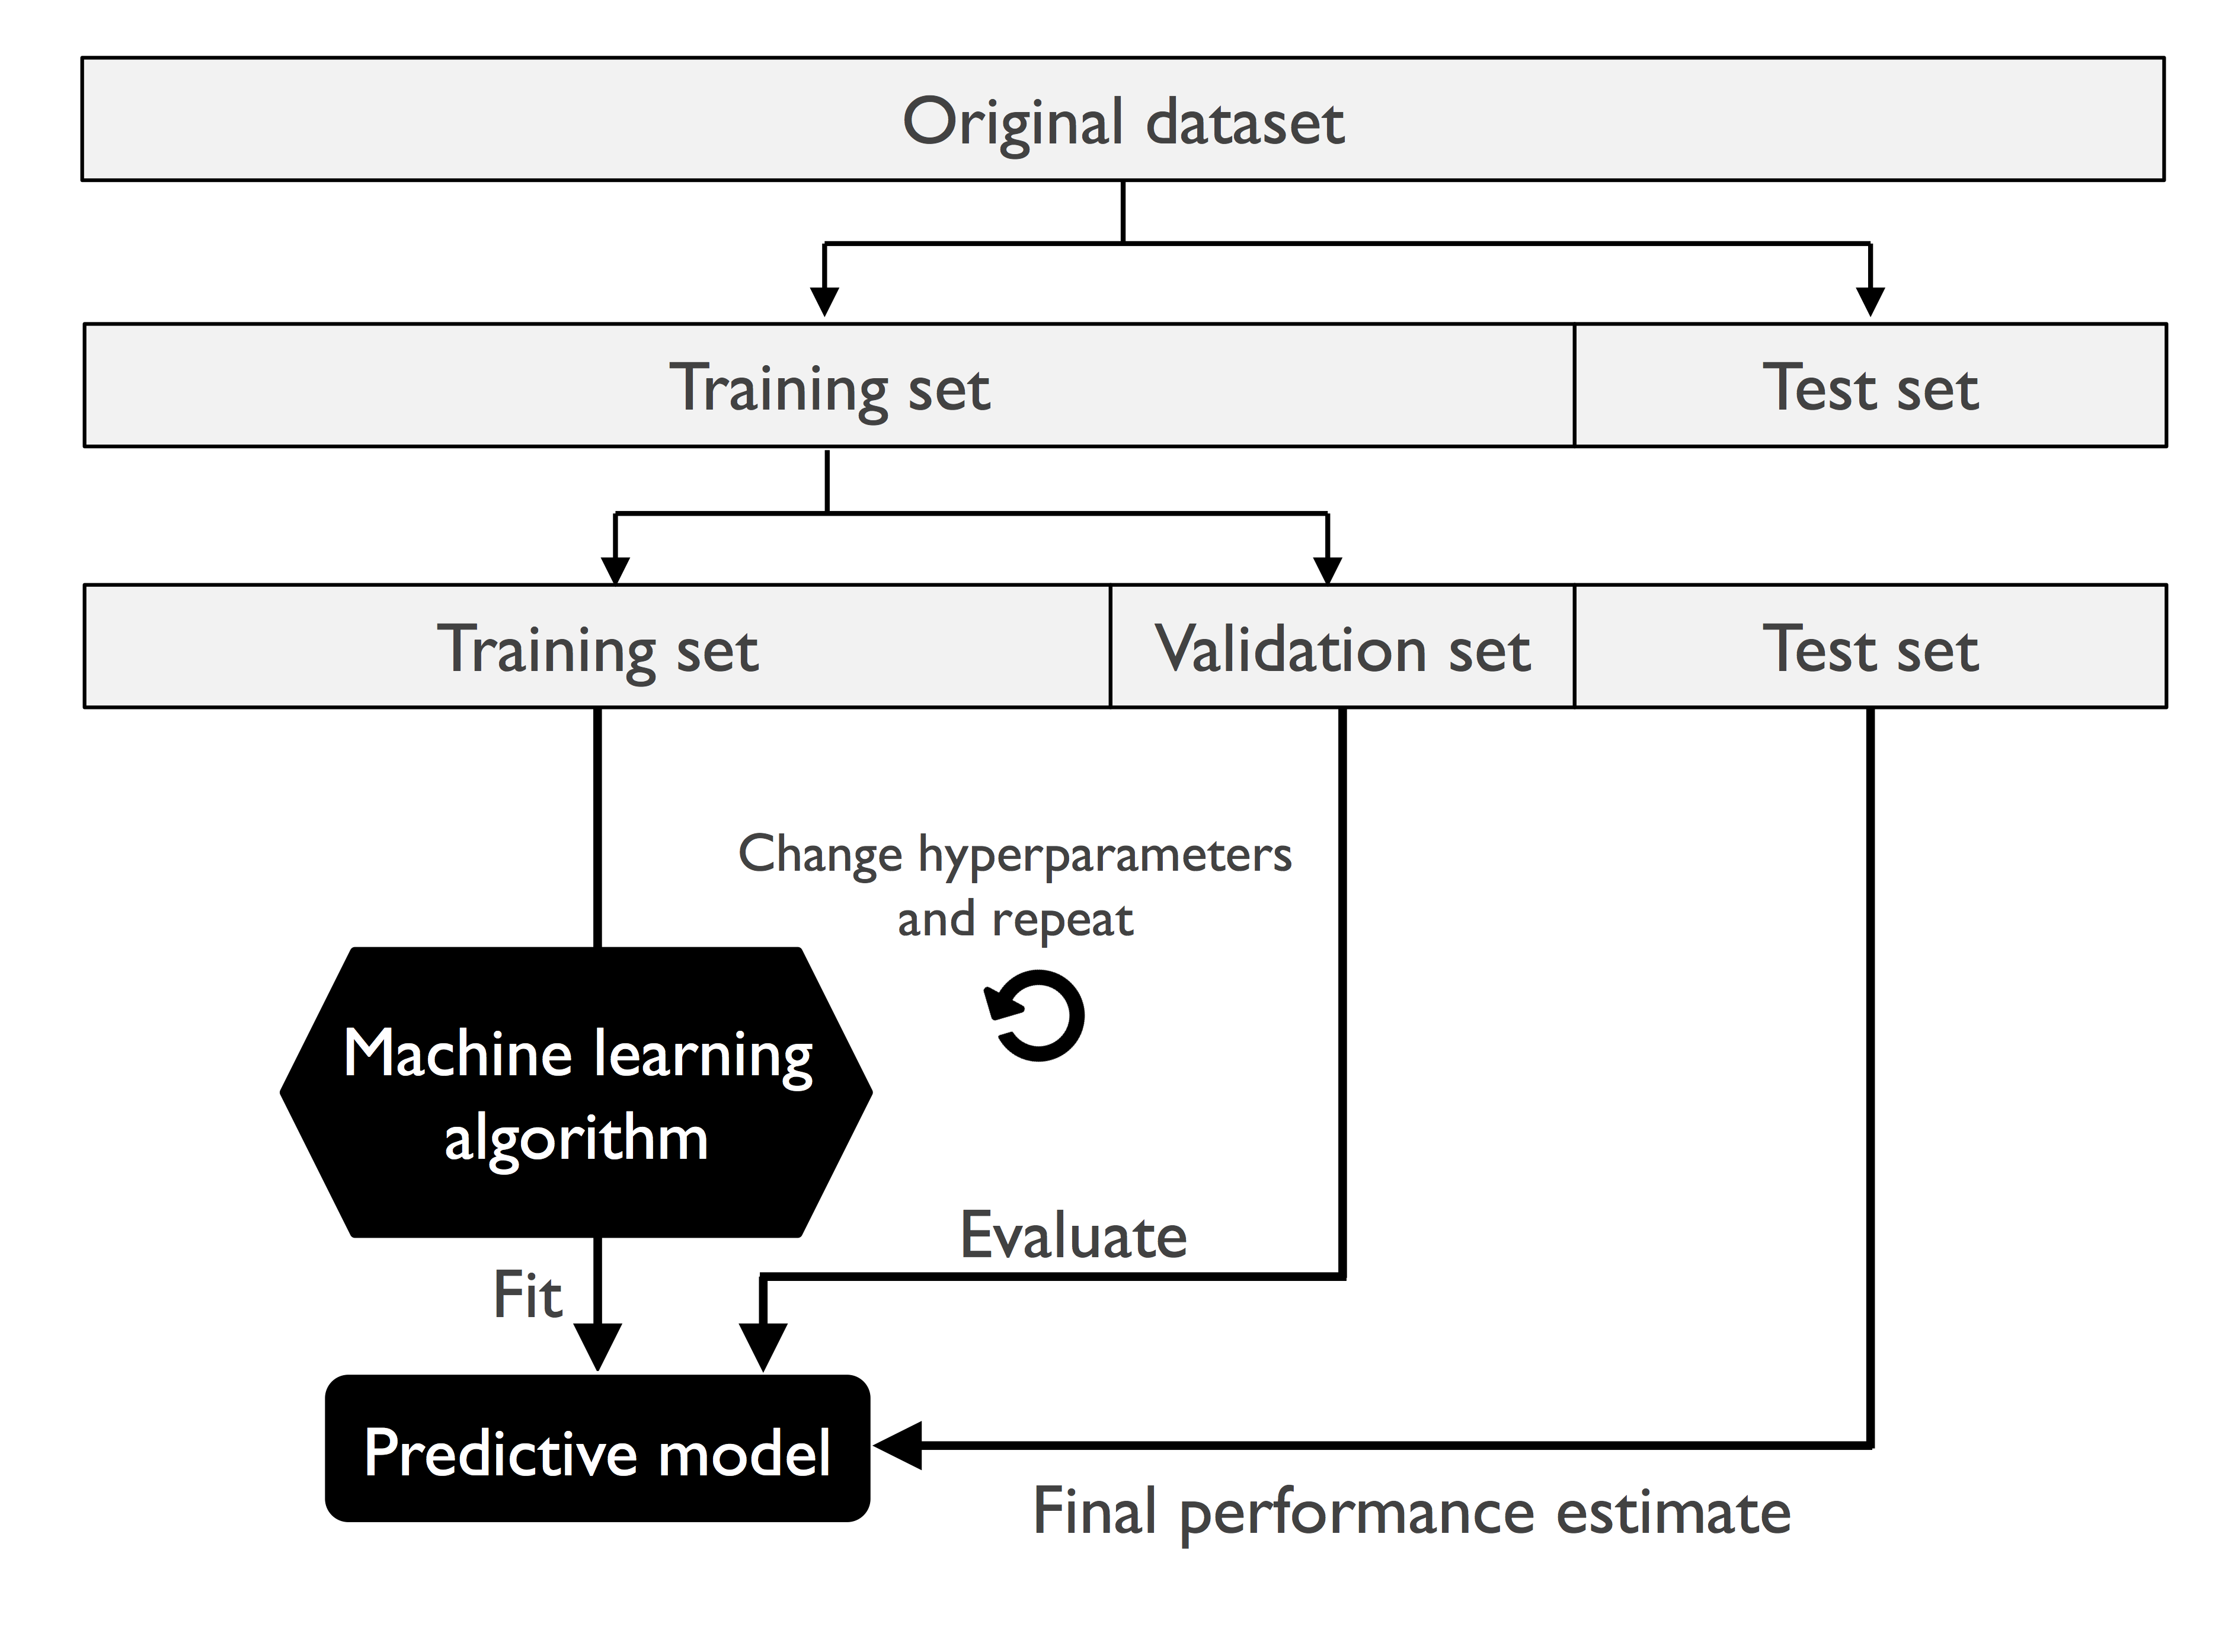

In [58]:
from IPython.display import Image
%matplotlib inline
Image(filename='06_02.png', width=500) 

### Create a Test Set and Train Set

It may sound strange to voluntarily set aside part of the data at this stage. After all, we have only taken a quick glance at the data, and surely we should learn a whole lot more about it before we decide what `algorithms` to use, `right?` This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to `overfitting`: if you look at the `test set`, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of `Machine Learning model`. When you estimate the `generalization error` using the test set, your estimate will be too optimistic and you will launch a system that will not perform as well as expected. This is called **data snooping bias**.



Creating a test set is theoretically quite simple: just pick some instances randomly, typically `20%` of the dataset, and set them aside:

`Scikit-Learn` provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split`, which does pretty well in splitting dataset, with a couple of additional features. First there is a `random_state` parameter that allows you to set the `random generator seed` as explained previously, and second you can pass it `multiple datasets` with an `identical number of rows`, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels:

#### Split the dataset into training and testing set

In [59]:
X = dataset.drop(['Chance_of_Admit'], axis=1)  # predictor
y = dataset['Chance_of_Admit'] # target(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # For reproducibilty

print('Size of X_test data is: ', X_test.shape)
print('Size of X_train data is: ', X_train.shape)
print('Size of y_test data is: ', y_test.shape)
print('Size of y_train data is: ', y_train.shape)

Size of X_test data is:  (80, 4)
Size of X_train data is:  (320, 4)
Size of y_test data is:  (80,)
Size of y_train data is:  (320,)


In [60]:
X_train.head()

University_Rating  LOR  CGPA  Research
3                    3  2.5  8.67         1
18                   3  3.0  8.80         0
202                  5  4.5  9.91         1
250                  3  2.5  8.57         1
274                  1  2.5  7.95         0

In [61]:
y_train.head()

3      0.80
18     0.63
202    0.97
250    0.74
274    0.58
Name: Chance_of_Admit, dtype: float64

In [62]:
X_test.head()

University_Rating  LOR  CGPA  Research
209                  3  4.0  8.12         1
280                  3  4.0  8.64         1
33                   5  4.0  9.60         1
210                  4  4.0  9.06         1
93                   2  3.0  7.88         1

In [64]:
# Create a copy of the train and test test so we don't harm the original dataset
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
X_test_copy = X_test.copy()
y_test_copy = y_test.copy()

#### Linear Regression

`LinearRegression` fits a `linear model` with `coefficients w = (w1, …, wp)` to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [68]:
# Instantiate you PREDICTOR
linear_model = LinearRegression()

#fit the model to the training dataset
linear_model.fit(X_train_copy, y_train_copy)

#obtain predictions
y_pred = linear_model.predict(X_test_copy)

print('Training Accuracy: %.3f' % linear_model.score(X_train_copy, y_train_copy))

Test Accuracy: 0.781


In [69]:
print('Linear Model is intercept (beta_0) :', linear_model.intercept_)
print('Coefficient of features (other betas) :', linear_model.coef_)

Linear Model is intercept (beta_0) : -0.7285692073155474
Coefficient of features (other betas) : [0.01183357 0.01282646 0.15770309 0.03534387]


#### Measuring Regression Performance

- Evaluation Metrics for performance (`RSS, R-Squared, RMSE, MAE` etc)

How well a regression model performs can be obtained by how close the predicted value is to the ground truth. It is very important to use the appropriate metric to evaluate the performance. 

In [71]:
# The mean squared error or mean squared deviation of an estimator measures the average of the squares of the errors, that is, 
# the average squared difference between the estimated values and the actual value.

# Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = (mean_squared_error(y_test_copy, y_pred))
print('Mean Squared Error : ', round(mse, 3))   

Mean Squared Error :  0.005


In [72]:
# MAE is easy and intuitive such that it calculates the sum of the average of the absolute error between the predicted
# values and the true values. Since the absolute difference is taken, this metric does not consider direction. 
# However, because the absolute difference is obtained, it is unable to give information about the model overshooting or 
# undershooting. The smaller the MAE is, the better the model. Therefore, if the MAE is 0, the model is perfect and accurately 
# predicts results which is almost impossible. The mean absolute error is more robust to outliers.

# Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_copy, y_pred)
print('Mean Absolute Error : ', round(mae, 3))

Mean Absolute Error :  0.049


In [73]:
# Also known as the sum of squared residuals (SSR), this metric explains the variance in the representation of the dataset 
# by the model; it measures how well the model approximates the data. A residual is the estimated error made by a model. 
# In simpler terms, it is the difference between the nth true value and the nth predicted value by the model. RSS is the sum 
# of the square of errors between the residuals in a model.The lower the RSS, the better the model’s estimations and vice versa.

# Residual Sum of Squares (RSS)
rss = np.sum(np.square(y_test_copy - y_pred))
print('Residual Sum of Squares : ', round(rss, 3))

Residual Sum of Squares :  0.4


In [74]:
# Root Mean Squared Error
# When the RMSE is low, it means that the error made by the model has a small deviation from the true values.

rmse = np.sqrt(mean_squared_error(y_test_copy, y_pred))
print('Root Mean Squared Error : ', round(rmse, 3))

Root Mean Squared Error :  0.071


In [75]:
# coefficient of determination, r-squared is a metric used in regression to determine the goodness of fit of the model. 
# With values ranging from 0 to 1, It gives information on the percentage of the response variable explained by the model. 
# Mostly, the higher the value, the better the model 

# R2 Score
from sklearn.metrics import r2_score
r2_score = r2_score(y_test_copy, y_pred)
print('Coefficient of Determination : ', round(r2_score, 2))

Coefficient of Determination :  0.81


### Data Storytelling of the LinearRegression Model Results

* -

* - 

### DecisionTreeRegressor

In [77]:
# Instantiate you PREDICTOR
tree_reg = DecisionTreeRegressor(random_state=42)

#fit the model to the training dataset
tree_reg.fit(X_train_copy, y_train_copy)

#obtain predictions
tree_y_pred = tree_reg.predict(X_test_copy)

print('Training Accuracy: %.3f' % tree_reg.score(X_train_copy, y_train_copy))

Training Accuracy: 0.983


In [78]:
# Root Mean Squared Error

rmse = np.sqrt(mean_squared_error(y_test_copy, tree_y_pred))
print('Root Mean Squared Error : ', round(rmse, 3))

Root Mean Squared Error :  0.1


In [79]:
# R2 Score
from sklearn.metrics import r2_score
r2_score = r2_score(y_test_copy, tree_y_pred)
print('Coefficient of Determination : ', round(r2_score, 2))

Coefficient of Determination :  0.61


### Data Storytelling of the DecisionTreeRegressor Model Results

* -

* - 

### RandomForestRegressor

In [80]:
# Instantiate you PREDICTOR
reg_model = RandomForestRegressor()

#fit the model to the training dataset
reg_model.fit(X_train_copy, y_train_copy)

#obtain predictions
reg_y_pred = reg_model.predict(X_test_copy)

# Model Accuracy
print('Training Accuracy: %.3f' % reg_model.score(X_train_copy, y_train_copy))

Training Accuracy: 0.945


In [81]:
# Root Mean Squared Error

rmse = np.sqrt(mean_squared_error(y_test_copy, reg_y_pred))
print('Root Mean Squared Error : ', round(rmse, 3))

Root Mean Squared Error :  0.077


In [82]:
# R2 Score
from sklearn.metrics import r2_score
r2_score = r2_score(y_test_copy, reg_y_pred)
print('Coefficient of Determination : ', round(r2_score, 2))

Coefficient of Determination :  0.77


### Data Storytelling of the DecisionTreeRegressor Model Results

* -

* - 

### GradientBoostingRegressor

In [85]:
# Instantiate you PREDICTOR
gbb_model = GradientBoostingRegressor()

#fit the model to the training dataset
gbb_model.fit(X_train_copy, y_train_copy)

#obtain predictions
gbb_y_pred = gbb_model.predict(X_test_copy)

# Model Accuracy
print('Training Accuracy: %.3f' % gbb_model.score(X_train_copy, y_train_copy))

Training Accuracy: 0.886


In [86]:
# Root Mean Squared Error

rmse = np.sqrt(mean_squared_error(y_test_copy, gbb_y_pred))
print('Root Mean Squared Error : ', round(rmse, 3))

Root Mean Squared Error :  0.078


In [87]:
# R2 Score
from sklearn.metrics import r2_score
r2_score = r2_score(y_test_copy, gbb_y_pred)
print('Coefficient of Determination : ', round(r2_score, 2))

Coefficient of Determination :  0.76


### Data Storytelling of the DecisionTreeRegressor Model Results

* -

* - 

# Better Evaluation Using Cross-Validation

A great way to implement this, is to use `Scikit-Learn’s cross-validation feature`. The following code performs `K-fold cross-validation`: it randomly splits the `training set` into `10` distinct subsets called `folds`, then it `trains` and `evaluates` the `model 10 times`, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the `10 evaluation scores`:

In [89]:
from sklearn.model_selection import cross_validate

# Cross validation on LinearRegression Model
scores = cross_validate(linear_model, X_train_copy, y_train_copy,
                         scoring=("neg_mean_squared_error", 'r2', 'neg_root_mean_squared_error'), cv=10)

In [90]:
scores

{'fit_time': array([0.50198984, 0.00401831, 0.00300097, 0.00400209, 0.00404286,
        0.06257057, 0.00400305, 0.00300288, 0.00299883, 0.00601554]),
 'score_time': array([0.07139134, 0.02721405, 0.00299716, 0.00298285, 0.00399232,
        0.00301242, 0.00299621, 0.00498509, 0.04834461, 0.00298667]),
 'test_neg_mean_squared_error': array([-0.00430031, -0.00289769, -0.00822762, -0.00393013, -0.00357978,
        -0.00457549, -0.0046212 , -0.00436662, -0.00383375, -0.00272381]),
 'test_r2': array([0.62897128, 0.84330198, 0.69884496, 0.7210803 , 0.75888047,
        0.76119654, 0.72311153, 0.76434366, 0.78589888, 0.88638953]),
 'test_neg_root_mean_squared_error': array([-0.06557675, -0.05383019, -0.09070623, -0.06269071, -0.05983124,
        -0.06764236, -0.0679794 , -0.06608037, -0.06191727, -0.05219014])}